In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

In [2]:
from math import ceil
from tqdm import tqdm

import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random


from bpd.pipelines.toy_ellips import pipeline_toy_ellips_samples
from bpd.pipelines.shear_inference import pipeline_shear_inference_ellipticities

In [3]:
seed = 42
key = random.key(seed)

g1 = 0.02
g2 = 0.0
true_g = jnp.array([g1, g2])

sigma_e = 1e-3
sigma_e_int = 4e-2
sigma_m = 1e-5
n_gals = 1000
n_samples_per_gal = 50

In [4]:
k1, k2 = random.split(key)

In [5]:
# positive shear
e_post_pos, _, _ = pipeline_toy_ellips_samples(k1, g1=g1, g2=g2, sigma_e=sigma_e, sigma_e_int=sigma_e_int, sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [6]:
# negative shear (same key!)
e_post_neg, _, _ = pipeline_toy_ellips_samples(k1, g1=-g1, g2=-g2, sigma_e=sigma_e, sigma_e_int=sigma_e_int, sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [7]:
e_post_pos.shape

(1000, 50, 2)

In [20]:
g_pos_samples = pipeline_shear_inference_ellipticities(k2, e_post_pos, true_g, sigma_e=sigma_e, sigma_e_int=sigma_e_int, n_samples=1000, initial_step_size=1e-3)

In [21]:
g_neg_samples = pipeline_shear_inference_ellipticities(k2, e_post_neg, -true_g, sigma_e=sigma_e, sigma_e_int=sigma_e_int, n_samples=1000, initial_step_size=1e-3)

In [60]:
g_pos_samples.shape

(1000, 2)

In [33]:
g_pos_samples[:, 0].std()

Array(3.37190099e-05, dtype=float64)

(array([ 6.,  4.,  9., 11., 17., 34., 42., 58., 73., 70., 72., 91., 80.,
        82., 73., 74., 61., 48., 37., 23., 16.,  9.,  5.,  4.,  1.]),
 array([-0.0201118 , -0.02010414, -0.02009648, -0.02008883, -0.02008117,
        -0.02007351, -0.02006586, -0.0200582 , -0.02005054, -0.02004288,
        -0.02003523, -0.02002757, -0.02001991, -0.02001226, -0.0200046 ,
        -0.01999694, -0.01998928, -0.01998163, -0.01997397, -0.01996631,
        -0.01995866, -0.019951  , -0.01994334, -0.01993568, -0.01992803,
        -0.01992037]),
 <BarContainer object of 25 artists>)

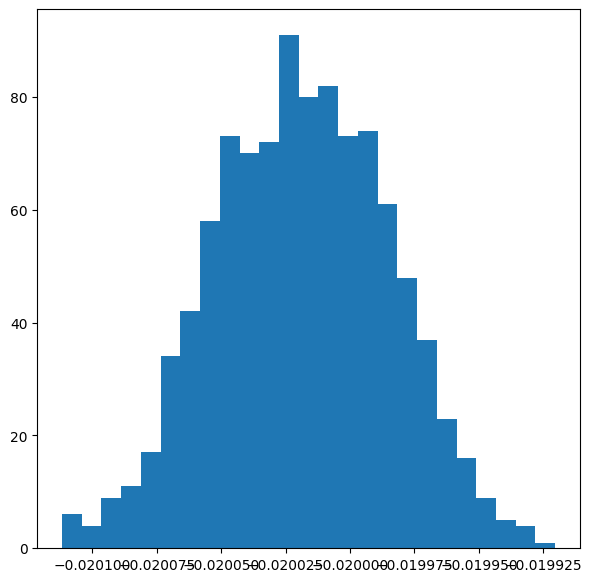

In [28]:
# plt.hist(g_pos_samples[:, 0], bins=25)
plt.figure(figsize=(7,7))
plt.hist(g_neg_samples[:, 0], bins=25)

In [34]:
g_best_samples = (g_pos_samples - g_neg_samples) * 0.5

(array([  1.,   1.,   2.,   3.,   2.,   1.,   6.,   3.,   8.,   7.,  24.,
         33.,  58., 129., 210., 292., 131.,  45.,  17.,  12.,   4.,   4.,
          3.,   2.,   2.]),
 array([0.01999981, 0.01999981, 0.01999981, 0.01999981, 0.01999981,
        0.01999981, 0.01999981, 0.01999981, 0.01999981, 0.01999981,
        0.01999981, 0.01999981, 0.01999981, 0.01999981, 0.01999981,
        0.01999981, 0.01999981, 0.01999981, 0.01999981, 0.01999981,
        0.01999981, 0.01999981, 0.01999981, 0.01999981, 0.01999981,
        0.01999981]),
 <BarContainer object of 25 artists>)

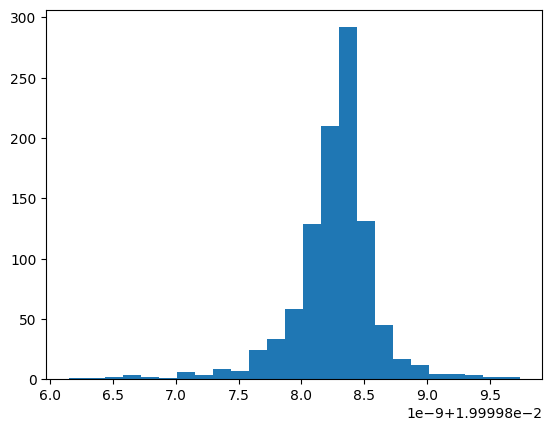

In [36]:
plt.hist(g_best_samples[:, 0], bins=25)

In [38]:
g_best_samples[:, 0].mean(), g_pos_samples[:, 0].mean()

(Array(0.01999981, dtype=float64), Array(0.01998104, dtype=float64))

In [44]:
g_best_samples[:, 0].std(), g_pos_samples[:, 0].std()

(Array(3.50319931e-10, dtype=float64), Array(3.3719104e-05, dtype=float64))

## Jackknife for error on the mean

In [ ]:
# let's start by splitting into 10 batches

# we only need to repeat the second step of the inference

In [8]:
e_post_pos.shape

(1000, 50, 2)

In [15]:
from math import ceil
n_batches = 10 # rule of thumb: ~100
batch_size = ceil(n_gals / n_batches)

# g_pos_list = [] 
# g_neg_list = []
g_best_list = [] 

keys = random.split(k2, n_batches)

for ii in range(n_batches): 
    print(ii)

    k_ii = keys[ii]
    start, end = ii * batch_size, (ii+1) * batch_size
    e_pos1 = jnp.concatenate([e_post_pos[:start], e_post_pos[end:]], axis=0)
    e_neg1 = jnp.concatenate([e_post_neg[:start], e_post_neg[end:]], axis=0)

    g_pos1 = pipeline_shear_inference_ellipticities(k_ii, e_post_pos, true_g, sigma_e=sigma_e, sigma_e_int=sigma_e_int, n_samples=1000, initial_step_size=1e-3)

    g_neg1 = pipeline_shear_inference_ellipticities(k_ii, e_post_neg, -true_g, sigma_e=sigma_e, sigma_e_int=sigma_e_int, n_samples=1000, initial_step_size=1e-3)

    g_best1 = (g_pos1 - g_neg1) * 0.5
    g_best_mean1 = g_best1.mean(axis=0)

    g_best_list.append(g_best_mean1)

    # g_pos_list.append(g_pos1)
    # g_neg_list.append(g_neg1)

# g_pos_jack = jnp.stack(g_pos_list, axis=0)
# g_neg_jack = jnp.stack(g_neg_list, axis=0)
g_best_means = jnp.array(g_best_list)

0
1
2
3
4
5
6
7
8
9


In [18]:
g_best_means.shape

(10, 2)

In [16]:
g_best_means[:, 0]

Array([0.01999975, 0.01999981, 0.01999981, 0.01999938, 0.01999988,
       0.01999977, 0.01999979, 0.01999971, 0.01999985, 0.01999981],      dtype=float64)

In [17]:
g_best_means[:, 0].mean() #g1

Array(0.01999976, dtype=float64)

In [19]:
# error on the mean (jackknife expression)
jnp.sqrt(g_best_means[:, 0].var() * (n_batches-1))

Array(3.96908294e-07, dtype=float64)

In [20]:
g_best_means[:, 0].mean() - 0.02

Array(-2.44035424e-07, dtype=float64)

In [58]:
g_

101

In [52]:
jnp.concatenate([e_post_pos[:100], e_post_neg[200:]], axis=0).shape

(900, 50, 2)